In [ ]:
pip install comet_ml -q

     |████████████████████████████████| 441 kB 7.6 MB/s 
     |████████████████████████████████| 54 kB 1.2 MB/s 
     |████████████████████████████████| 130 kB 13.4 MB/s 
     |████████████████████████████████| 168 kB 44.2 MB/s 
     |████████████████████████████████| 54 kB 686 kB/s 
     |████████████████████████████████| 498 kB 30.3 MB/s 
     |████████████████████████████████| 140 kB 39.1 MB/s 
     |████████████████████████████████| 127 kB 22.4 MB/s 
     |████████████████████████████████| 168 kB 29.9 MB/s 
     |████████████████████████████████| 166 kB 31.7 MB/s 
     |████████████████████████████████| 166 kB 22.0 MB/s 
     |████████████████████████████████| 162 kB 14.3 MB/s 
     |████████████████████████████████| 162 kB 51.2 MB/s 
     |████████████████████████████████| 158 kB 41.2 MB/s 
     |████████████████████████████████| 157 kB 9.9 MB/s 
     |████████████████████████████████| 157 kB 17.0 MB/s 
     |████████████████████████████████| 157 kB 24.8 MB/s 
     |██████████████

In [ ]:
import os
from getpass import getpass

API_KEY = getpass('Enter Comet. ml API key:')

os.environ['COMET_API_KEY'] = API_KEY

Enter Comet. ml API key:··········


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Load data
data_df = pd.read_csv('/content/drive/MyDrive/MMD6020_Final_Project/data/processed/chbmit_preprocessed_data.csv') 

# Separate X and y
X = data_df.drop(['Outcome'], axis=1)
y = data_df['Outcome']

# Split into train,validation and test
X_train, X_val_test, y_train, y_val_test = train_test_split(X,y,test_size=0.2, stratify=y, random_state=666)
X_val, X_test, y_val, y_test = train_test_split(X_val_test,y_val_test,test_size=0.5, stratify=y_val_test, random_state=666)

# Visualization 

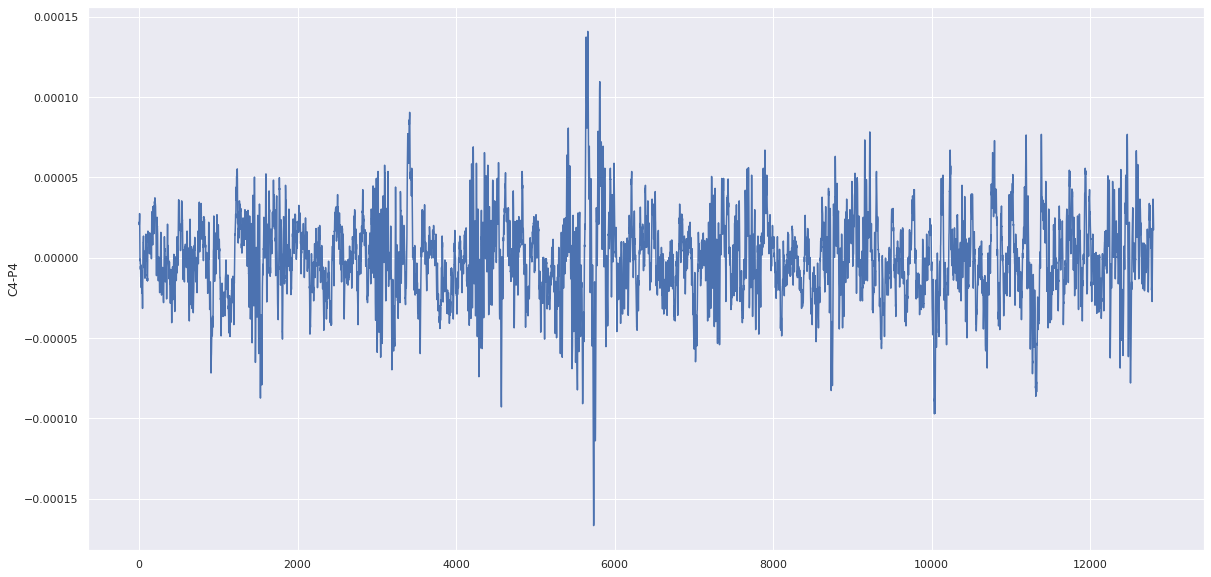

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

timepoints = list(data_df.index)

# Plot time series
sec = 50
plt.figure(figsize=(20, 10))
sns.lineplot(data=data_df[:256*sec], x=timepoints[:256*sec], y=data_df.iloc[:256*sec,2])

In [ ]:
# Visualize data distribution for each channel

fig, axes = plt.subplots(len(X.columns)//3, 3, figsize=(12, 48))

i = 0
for triaxis in axes:
    for axis in triaxis:
        X.hist(column = X.columns[i], bins = 100, ax=axis)
        i = i+1

# Model Training


In [3]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import numpy as np

# Define metrics
def evaluate(y_true, y_proba):
    y_pred = np.round(y_proba)
    return {
        'Precision': precision_score(y_true, y_pred, average='macro'),
        'Recall': recall_score(y_true, y_pred, average='macro'),
        'Macro f1': f1_score(y_true, y_pred, average='macro'),
        'Accuracy': accuracy_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_proba)
    }

## AdaBoost

In [8]:
from sklearn.ensemble import AdaBoostClassifier

# Baseline Model
clf_adaboost = AdaBoostClassifier(random_state=RANDOM_SEED)
clf_adaboost.fit(X_train, y_train)

y_pred_train = clf_adaboost.predict(X_train)
train_metrics = evaluate(y_train, y_pred_train)
print('On training data: ', train_metrics)

y_pred_val = clf_adaboost.predict(X_val)
val_metrics = evaluate(y_val, y_pred_val)
print('On validation data: ', val_metrics)

On training data:  {'Precision': 0.7887114240313636, 'Recall': 0.7868970984431252, 'Macro f1': 0.7865617753486266, 'Accuracy': 0.7868970984431252, 'ROC AUC': 0.7868970984431253}
On validation data:  {'Precision': 0.7886963428792714, 'Recall': 0.7869443718944695, 'Macro f1': 0.7866204992275954, 'Accuracy': 0.7869441861574041, 'ROC AUC': 0.7869443718944695}


In [32]:
np.linspace(0.1, 1, num=10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

tuned_parameters = {
  "n_estimators": np.linspace(20, 100, num=11),
  "learning_rate": np.linspace(0.1, 1, num=10),
  }

cv = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)

random_search = RandomizedSearchCV(
    AdaBoostClassifier(random_state=RANDOM_SEED), 
    tuned_parameters, 
    n_iter=150, 
    scoring='accuracy', 
    cv=cv,
)
random_search.fit(X_train, y_train);
print('Finished!')

In [ ]:
print("Meilleur ensemble de paramètres trouvé")
print()
print(random_search.best_params_)
print(random_search.best_score_)

In [ ]:
# Use "gpu_hist" for training the model.
adaboost_HP =  AdaBoostClassifier(n_estimators=random_search.best_params_["n_estimators"],
                                  learning_rate=random_search.best_params_["learning_rate"],
                                  random_state=RANDOM_SEED)

# Fit the model using predictor X and response y.
adaboost_HP.fit(X_train, y_train)

y_pred_train = adaboost_HP.predict(X_train)
train_metrics = evaluate(y_train, y_pred_train)
print('On training data: ', train_metrics)

y_pred_val = adaboost_HP.predict(X_val)
test_metrics = evaluate(y_val, y_pred_val)
print('On validation data: ', test_metrics)

## Logistic Regression

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
from sklearn.linear_model import LogisticRegression

# Baseline Model
clf_logreg = LogisticRegression(random_state=RANDOM_SEED)
clf_logreg.fit(X_train, y_train)

y_pred_train = clf_logreg.predict(X_train)
train_metrics = evaluate(y_train, y_pred_train)
print('On training data: ', train_metrics)

y_pred_val = clf_logreg.predict(X_val)
val_metrics = evaluate(y_val, y_pred_val)
print('On validation data: ', val_metrics)

On training data:  {'Precision': 0.504481852409979, 'Recall': 0.5044810814677061, 'Macro f1': 0.5044597714782673, 'Accuracy': 0.5044810814677062, 'ROC AUC': 0.5044810814677061}
On validation data:  {'Precision': 0.5030737088669678, 'Recall': 0.5030732476217428, 'Macro f1': 0.5030545898358765, 'Accuracy': 0.5030732184154686, 'ROC AUC': 0.5030732476217428}


In [6]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import numpy as np

tuned_parameters = {
  "penalty": ["l1", "l2", "elasticnet", "none"],
  "C": [0.01, 0.05, 0.1, 0.5, 0.7, 1.0, 5, 10, 20, 50, 70, 100],
  "max_iter": np.linspace(100, 1000, num=11),
  }

cv = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)

random_search = RandomizedSearchCV(
    LogisticRegression(solver='saga', class_weight=None, random_state=RANDOM_SEED), 
    tuned_parameters, 
    n_iter=2, 
    scoring='accuracy', 
    cv=cv,
)
random_search.fit(X_train, y_train);
print('Finished!')

KeyboardInterrupt: ignored

In [ ]:
print("Meilleur ensemble de paramètres trouvé")
print()
print(random_search.best_params_)
print(random_search.best_score_)

In [ ]:
logreg_HP = LogisticRegression(penalty = random_search.best_params_['penalty'],
                               C = random_search.best_params_['C'],
                               max_iter = random_search.best_params_['max_iter'],
                               solver='saga', 
                               class_weight=None, 
                               random_state=RANDOM_SEED)
                               
# Fit the model using predictor X and response y.
logreg_HP.fit(X_train, y_train)

y_pred_train = logreg_HP.predict(X_train)
train_metrics = evaluate(y_train, y_pred_train)
print('On training data: ', train_metrics)

y_pred_val = logreg_HP.predict(X_val)
test_metrics = evaluate(y_val, y_pred_val)
print('On validation data: ', test_metrics)

## Random Forest

## KNN

## XGBoost

In [7]:
import xgboost as xgb

# Use "gpu_hist" for training the model.
clf_xgb = xgb.XGBClassifier(tree_method="gpu_hist")
# Fit the model using predictor X and response y.
clf_xgb.fit(X_train, y_train)

# Baseline model
y_pred_train = clf_xgb.predict(X_train)
train_metrics = evaluate(y_train, y_pred_train)
print('On training data: ', train_metrics)

y_pred_val = clf_xgb.predict(X_val)
val_metrics = evaluate(y_val, y_pred_val)
print('On validation data: ', val_metrics)

On training data:  {'Precision': 0.8039725136034956, 'Recall': 0.8027400281334192, 'Macro f1': 0.8025398729165341, 'Accuracy': 0.8027400281334192, 'ROC AUC': 0.8027400281334193}
On validation data:  {'Precision': 0.8041977246056933, 'Recall': 0.8030376028374919, 'Macro f1': 0.8028495159488491, 'Accuracy': 0.8030374555944972, 'ROC AUC': 0.8030376028374919}


In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

tuned_parameters = {
  'gamma': np.linspace(0, 2, num=50),
  'max_depth': np.linspace(0, 12, num=13, dtype=int),
  'eta':np.linspace(0,1,num=11, dtype =int)
  }

cv = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)

random_search = RandomizedSearchCV(
    xgb.XGBClassifier(tree_method="gpu_hist"), 
    tuned_parameters, 
    n_iter=10, 
    scoring='accuracy', 
    cv=cv,
)
random_search.fit(X_train, y_train);
print('Finished!')

Finished!


In [22]:
print("Meilleur ensemble de paramètres trouvé")
print()
print(random_search.best_params_)
print(random_search.best_score_)

Meilleur ensemble de paramètres trouvé

{'max_depth': 12, 'gamma': 0.2040816326530612, 'eta': 0}
0.8536168132942326


In [23]:
# Use "gpu_hist" for training the model.
xgb_HP = xgb.XGBClassifier(tree_method="gpu_hist", 
                           # scale_pos_weight = random_search.best_params_['scale_pos_weight'], 
                           max_depth = random_search.best_params_['max_depth'], 
                           # max_delta_step = random_search.best_params_['max_delta_step'], 
                           gamma = random_search.best_params_['gamma'], 
                           eta = random_search.best_params_['eta'])
# Fit the model using predictor X and response y.
xgb_HP.fit(X_train, y_train)

y_pred_train = xgb_HP.predict(X_train)
train_metrics = evaluate(y_train, y_pred_train)
print('On training data: ', train_metrics)

y_pred_val = xgb_HP.predict(X_val)
val_metrics = evaluate(y_val, y_pred_val)
print('On validation data: ', val_metrics)

On training data:  {'Precision': 0.8717621896454762, 'Recall': 0.8697285601888277, 'Macro f1': 0.8695501621158626, 'Accuracy': 0.8697285601888277, 'ROC AUC': 0.8697285601888278}
On validation data:  {'Precision': 0.8574943634059973, 'Recall': 0.8561477752596754, 'Macro f1': 0.8560120587254523, 'Accuracy': 0.8561476289249697, 'ROC AUC': 0.8561477752596756}


# Plot Calibration Curve

In [17]:
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set()

colors = ['red', 'blue', 'green', 'yellow', 'orange']

def plot_Calibration(classifiers_tuple, plot_name, add_random=False):
    calibration_displays = {}
    fig = plt.figure(figsize=(8, 8))
    gs = GridSpec(2, 2)
    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    nbins = 10

    for count, classifier in enumerate(classifiers_tuple):

        clf = classifier[0]
        clf_name = classifier[1]
        X = classifier[2]
        y = classifier[3]
        y_pred = clf.predict_proba(X)[:,1]
        
        display = CalibrationDisplay.from_predictions(y, y_pred, n_bins=nbins, name=clf_name, ax=ax_calibration_curve, color=colors[count])
        calibration_displays[clf_name] = display

    if add_random:
        y_random = np.random.uniform(low=0.0, high=1.0, size=len(y))
        CalibrationDisplay.from_predictions(y, y_random, n_bins=nbins, name='Random Uniform', ax=ax_calibration_curve, color='black')

    ax_calibration_curve.set_title("Calibration plots");
    plt.legend(loc="upper left")

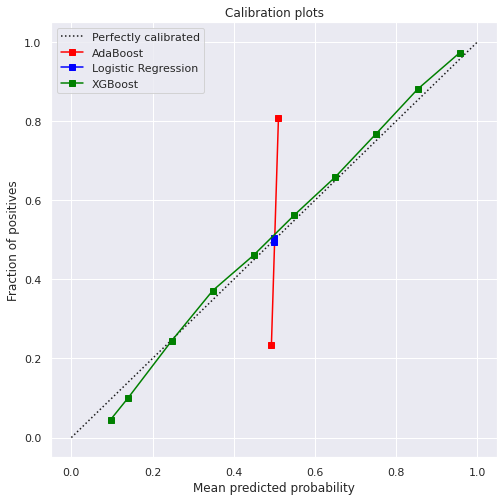

In [19]:
classifiers = [(clf_adaboost, 'AdaBoost', X_test, y_test),
               (clf_logreg, 'Logistic Regression', X_test, y_test),
               # (rf_HP, 'Random Forest', X_test, y_test),
               # (knn_HP, 'KNN', X_test, y_test)
               (clf_xgb, 'XGBoost', X_test, y_test)]
plot_Calibration(classifiers, plot_name='Testing')

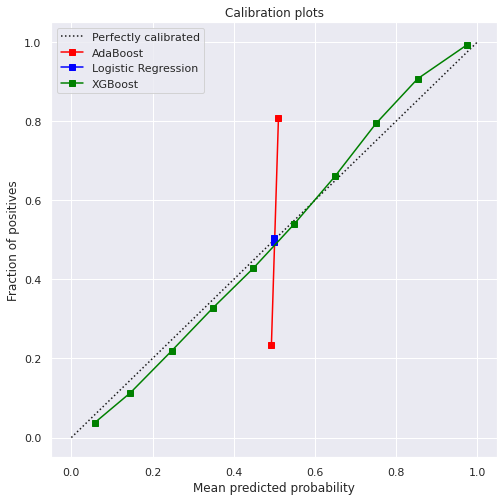

In [24]:
classifiers = [(clf_adaboost, 'AdaBoost', X_test, y_test),
               (clf_logreg, 'Logistic Regression', X_test, y_test),
               # (rf_HP, 'Random Forest', X_test, y_test),
               # (knn_HP, 'KNN', X_test, y_test)
               (xgb_HP, 'XGBoost', X_test, y_test)]
plot_Calibration(classifiers, plot_name='Testing')

# Plot ROC

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

colors = ['red', 'blue', 'green', 'yellow', 'orange']

def plot_ROC(classifiers_tuple, plot_name, add_random=True):

    plt.figure(figsize=(8, 8))

    for count, classifier in enumerate(classifiers_tuple):

        
        clf = classifier[0]
        clf_name = classifier[1]
        X = classifier[2]
        y = classifier[3]

        y_pred = clf.predict_proba(X)[:,1]
        fpr, tpr, _ = roc_curve(y.ravel(), y_pred.ravel())
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color=colors[count], label=f"{clf_name}: AUC = %0.2f" % roc_auc)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curves")

    if add_random:
        plt.plot([0, 1], [0, 1], color="black", label='Random Uniform (AUC = 0.5)', linestyle="--")
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.legend(loc="lower right")

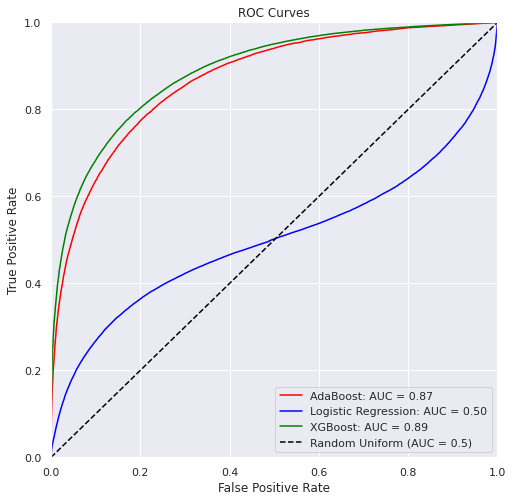

In [12]:
classifiers = [(clf_adaboost, 'AdaBoost', X_test, y_test),
               (clf_logreg, 'Logistic Regression', X_test, y_test),
               # (rf_HP, 'Random Forest', X_test, y_test),
               # (knn_HP, 'KNN', X_test, y_test)
               (clf_xgb, 'XGBoost', X_test, y_test)]
plot_ROC(classifiers, plot_name='Testing', add_random=True)

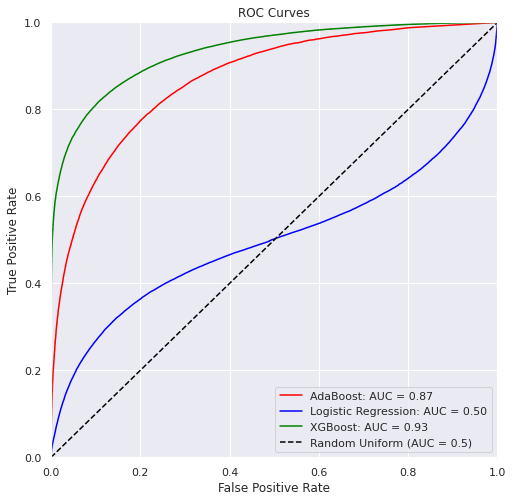

In [25]:
classifiers = [(clf_adaboost, 'AdaBoost', X_test, y_test),
               (clf_logreg, 'Logistic Regression', X_test, y_test),
               # (rf_HP, 'Random Forest', X_test, y_test),
               # (knn_HP, 'KNN', X_test, y_test)
               (xgb_HP, 'XGBoost', X_test, y_test)]
plot_ROC(classifiers, plot_name='Testing', add_random=True)